# IndabaX HACKATHON

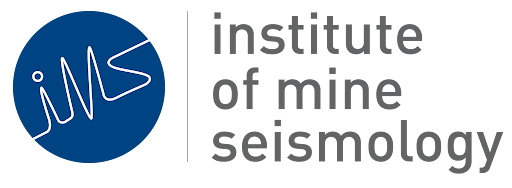

Author: Francois Naude

Contact: francois.naude@imseismology.org

In this guided hackathon you will implement and tune a model that is critical to the safety of mine workers and also helps keep mines running. You will try to produce a model that is able to give seismologists (people who analyse seismic events, like earthquakes) all the information they need to locate the origin and size of seismic events so that they can send rescue teams or give warnings of unsafe areas. Let's get started! 

In [1]:
### Get the packages to equip you for building and testing models

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import tensorflow as tf
from tensorflow.keras.losses import KLDivergence

### Fetch support functions to feed our model
%run ./Utils.ipynb

### Inspect the data

In [2]:
### COMPLETE FOR HACKATHON
def InspectFunction(X,labels,fileIdx,w = 8192):
    pIdx = labels[0]
    sIdx = labels[1]

    plt.plot(X[:w])
    plt.show()
    # Plot A single seismogram...Continue


In [3]:
## List of files within the directory
dataDir = "J:\\HacakthonIMS\\trailTrain\\"

fileList = sorted(os.listdir(dataDir))

## Read in n files (CHANGE ME)
startFile = 0
numFiles = 5    
w = 8192   # length of signal (Seismogram) 

## Iterate through files and plot with inspect_function()
for fileIdx,fileName in enumerate(fileList[startFile:(startFile+numFiles)]):
    ## Read in the file as a dataframe df
    filePath = os.path.join(dataDir, fileName)
    with gzip.open(filePath, 'rt') as file:
        ## extract p and s labels
        firstLine = file.readline().strip()
        ## extract seismogram as colomns of x,y,z
        df = pd.read_csv(file,header=None, engine='python')
   
    ## Extract information from the dataframe
    labels = np.array(firstLine.split(','), dtype=int)
    X = df.iloc[0:, :3]

    ## Inspect a single example usinf your plot_function
    InspectFunction(X,labels,fileIdx)

FileNotFoundError: [WinError 3] The system cannot find the path specified: '\\Users\\engguest\\Documents\\pracDATA\\'

### Build a data generator

In [13]:
### Initialize a training data generator (CHOOSE PARAMETERS)
batchSize = 1
trainGen = DataGenerator(dataDir, batch_size = batchSize, max_files = 1000) # "max_files = None " uses all the files
# trainGen.total_len()

### Inspect the data generator

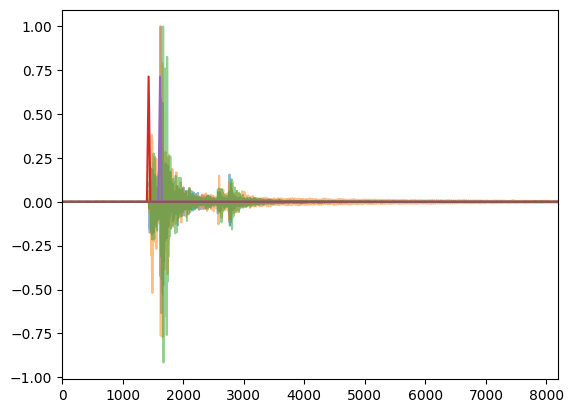

In [14]:
for i in range(batchSize):
    ### Plot the seismogram and labels
    batchNumber = 2  # Batch number
    fileNumber = i   # File number in batch (max is batch_size - 1)
    
    singleSeismogramData = trainGen[batchNumber][0][fileNumber][0]
    singleSeismogramLabel = trainGen[batchNumber][1][fileNumber][0]
    
    plt.plot(singleSeismogramData, alpha = 0.5)
    plt.plot(singleSeismogramLabel*20)    # Use the scalar for visual purposes
    plt.xlim(0,8192)                      # Trim plot for visual inspection eg. 4096 instead of 8192
    plt.show()

In [ ]:
### BUILD a validation dataset... COMPLETE
valDir = "J:\\HacakthonIMS\\Validate1000\\"


### Build a model

In [ ]:
### Build your custom model if you are feeling confident (You can skip this) 
def CustomModel(input_size=(1, 8192, 3)): # Keep the same output size.
    inputs = Input(shape=input_size)

    ##### Example: 
    filter_shape = (1, 7)
    output = Conv2D(3, filter_shape, activation="relu", padding="same")(inputs) # The 3 is the number of channels, which for the final layer is 3
    ##### replace this block

    model = Model(inputs=inputs, outputs=output)
    return model

In [15]:
# Inputs and Outputs: (1,8192,3)
model = UNetModel()  # change to your own custom model, or keep default "UNetModel()"
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001, clipvalue = 1.0),
            loss='mse'
            # loss=KLDivergence()
)

### Train a model

In [ ]:
# ADD a validation dataGenerator to the training
history = model.fit(trainGen, epochs = 10)

### Analyse training

In [ ]:
# GET the validation loss 'val_loss' once implemented
loss = history.history['loss']

In [ ]:
plt.plot(loss)
plt.show()

### Predict on a test set

In [ ]:
# BUILD a testset datagenerator
testDir = "J:\\HacakthonIMS\\Test1000\\"

## This is a challenge testSet of 6 seismograms
testDir = "J:\\HacakthonIMS\\Challenge\\"

In [ ]:
### The training dataset "trainGen" is used here. USE YOUR testGenerator INSTEAD.
Predictions = model.predict(trainGen)

### Analyse predictions

In [ ]:
print(Predictions.shape)

In [ ]:
for seismogramNum in range(5):
    plt.plot(Predictions[seismogramNum][0][:,:2])
    plt.xlim()
    plt.show()

### Model Performance

In [ ]:
### Histogram
# Negative means the Pick is after the label (Late) and Positive is Early
fig = resultsHistogram(Preds = Predictions,dataGen = trainGen) 

In [ ]:
### Still feeling curious?
# Explore the Utils notebook to customise further. Remember to save the Utils notebook to a new checkpoint 
# and to run the first cell of this notebook: or run the command " %run ./Utils.ipynb " in a cell to update your changes.